In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.signal import find_peaks, convolve
import matplotlib as mpl
from glob import glob

%matplotlib widget


In [85]:
s21 = np.load('VNAsweep_s21_5-9GHz.npy')
freqs = np.load('VNAsweep_freqs_5-9GHz.npy')

400


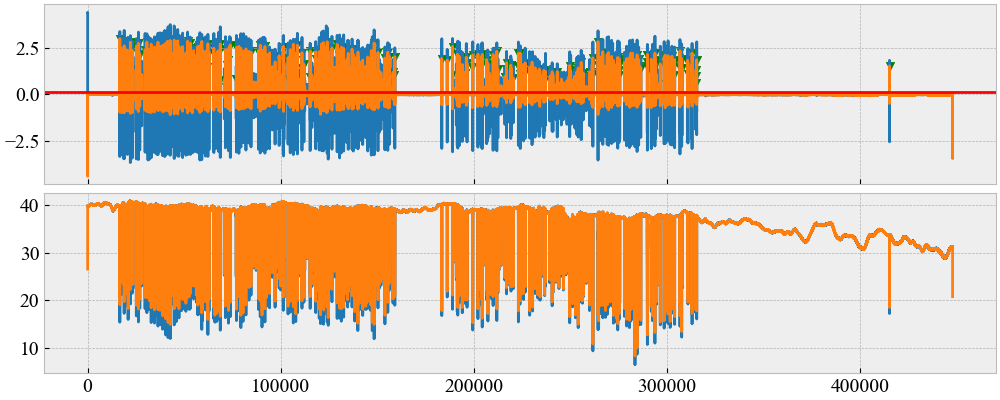

In [143]:
sw = 3
mph = 0.11
window = np.ones(sw)/sw
smooth_s21 = convolve(s21, window, mode='same')
ds21 = np.diff(smooth_s21, 1)
smooth_ds21 = np.convolve(ds21, window)
d2s21 = np.diff(smooth_ds21, 1)

fig, ax = plt.subplot_mosaic('a;b', sharex=True, figsize=(10, 4), constrained_layout=True)
ax['a'].plot(smooth_ds21)
ax['a'].plot(d2s21)
ax['a'].axhline(mph, c='r')
ax['b'].plot(s21)
ax['b'].plot(smooth_s21)

locs, props = find_peaks(d2s21, height=mph, prominence=mph/2)
heights = props['peak_heights']
ax['a'].scatter(locs, heights, marker='v', c='g')
print(len(locs))

(0.0, 50.0)

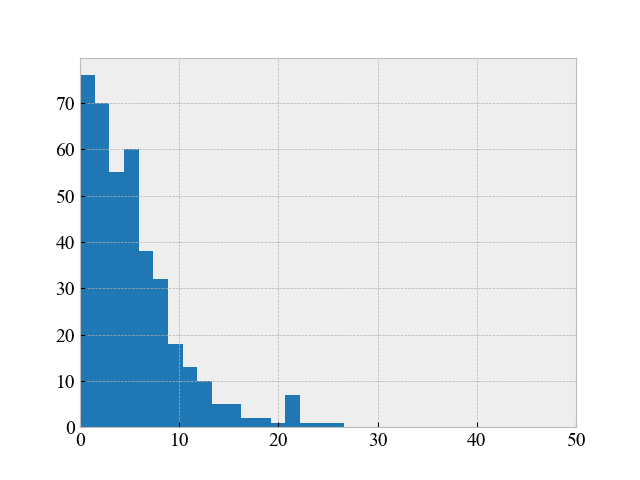

In [144]:
fs = freqs[locs]*1e9
dfs = fs[1:]-fs[:-1]
Q = 5e4
F0 = 6e9
fwhm = F0 / Q
dfwhms = dfs / fwhm
fig, ax = plt.subplots()
_ = ax.hist(dfs*1e-6, bins='auto')
ax.set_xlim(0, 50)
# _ = ax.hist(dfwhms, bins='auto')
# ax.set_xlim(0, 500)

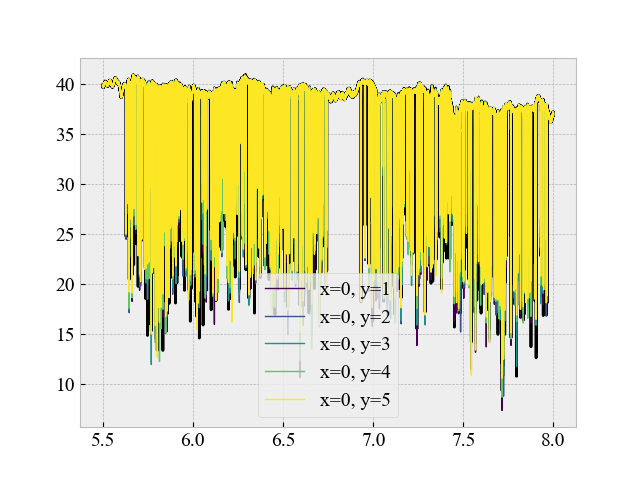

In [58]:
dir = 'S21s/30-05-24_wx_x/*'
files = glob(dir + '2024.npy')[:5]
freqs = np.load(glob(dir + 'freqs.npy')[0])
dark = np.load(glob(dir + 'dark.npy')[0])
fig, ax = plt.subplots()
ax.plot(freqs, dark, c='k')
colors = colormaps['viridis'](np.linspace(0, 1, len(files)))
for i, file in enumerate(files):
    data = np.load(file)
    coords = file.split('_')[3]
    y = int(coords.split('y')[-1])
    x = int(coords.split('y')[0][1:])
    ax.plot(freqs, data, c=colors[i], lw=1, label='x=%d, y=%d' % (x, y))
ax.legend()

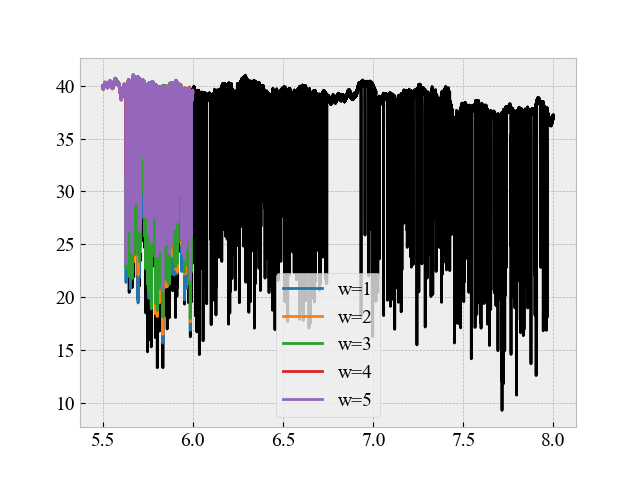

In [68]:
dir = 'S21s/30-05-24/*'
files = glob(dir + '2024.npy')
freqs = np.load(glob(dir + 'freqs.npy')[1])
freqs_dark = np.load(glob(dir + 'freqs.npy')[0])
dark = np.load(glob(dir + 'dark.npy')[0])
fig, ax = plt.subplots()
ax.plot(freqs_dark, dark, c='k')
for file in files[:5]:
    data = np.load(file)
    w = int(file.split('_')[2][1:])
    color = file.split('_')[3]
    if color == 'white':
        color = 'cyan'
    ax.plot(freqs, data, label='w=%d' % w)
ax.legend()

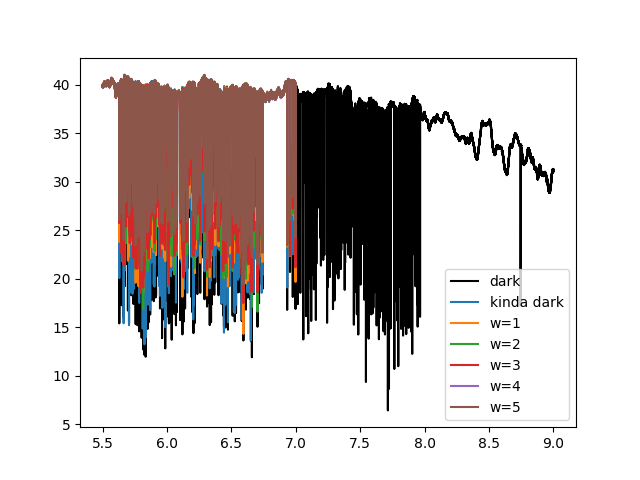

In [10]:
dir = 'S21s/31-05-24/*'
files = glob(dir + '2024.npy')[1:]
freqs = np.load(glob(dir + '*freqs.npy')[0])
freqs_dark = np.load(glob(dir + 'VNA*freqs*.npy')[0])
dark = np.load(glob(dir + 'VNA*s21*.npy')[0])
kinda_dark = np.load(glob(dir + 'dark*.npy')[0])
fig, ax = plt.subplots()
ax.plot(freqs_dark, dark, c='k', label='dark')
ax.plot(freqs, kinda_dark, label='kinda dark')
for file in files[:5]:
    data = np.load(file)
    w = int(file.split('_')[2][1:])
    color = file.split('_')[3]
    if color == 'white':
        color = 'cyan'
    ax.plot(freqs, data, label='w=%d' % w)
ax.legend()

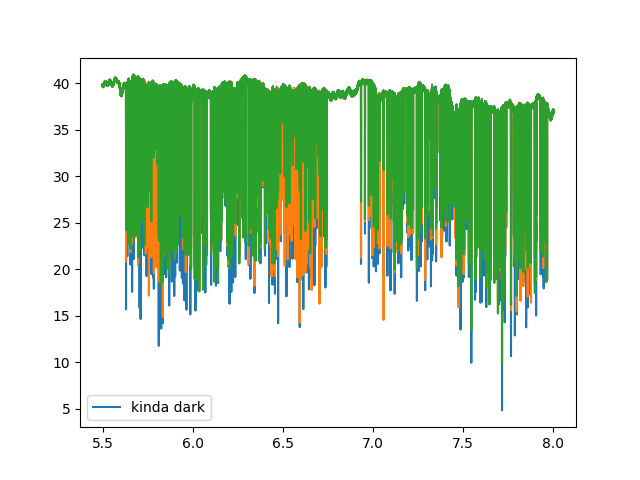

In [19]:
dir = 'S21s/LT343/31-05-24_mapping_20x20/*12h39*'
files = glob(dir + '2024.npy')
freqs = np.load(glob(dir + '*freqs.npy')[0])
# freqs_dark = np.load(glob(dir + 'VNA*freqs*.npy')[0])
# dark = np.load(glob(dir + 'VNA*s21*.npy')[0])
kinda_dark = np.load(glob(dir + 'dark*.npy')[0])
fig, ax = plt.subplots()
# ax.plot(freqs_dark, dark, c='k', label='dark')
ax.plot(freqs, kinda_dark, label='kinda dark')
for file in files:
    data = np.load(file)
    # w = int(file.split('_')[2][1:])
    color = file.split('_')[3]
    if color == 'white':
        color = 'cyan'
    ax.plot(freqs, data)
ax.legend()

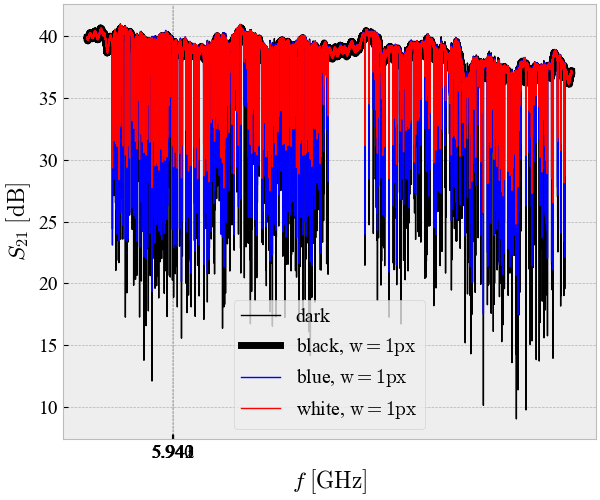

In [21]:
dir = 'S21s/30-05-24/S21_x580y1020_'
date = '15h36_30-5-2024'
darkname = dir + date + '_dark.npy'
date = '15h37_30-5-2024'
freqsname = dir + date + '_freqs.npy'
freqs = np.load('S21s/30-05-24/S21_x540y1120_15h37_30-5-2024_freqs.npy')
dark = np.load('S21s/30-05-24/S21_w5_blue_15h36_30-5-2024_dark.npy')

def get_s21(w, c):
    dir = 'S21s/30-05-24/S21_x540y1120'
    date = '15h37_30-5-2024'
    name = '%s_w%d_%s_%s.npy' % (dir, w, c, date)
    return np.load(name) 

fig, ax = plt.subplots(figsize=(6, 5), constrained_layout=True)
w = 1
ax.plot(freqs, dark, c='k', lw=w, label='dark')
ax.set_xlabel('$\it f$ $[GHz]$')
ax.set_ylabel('$\it S_{21}$ $[dB]$')
# ax.set_title('Transmission 400 pixels on single readout line')
# ax.plot(freqs, get_s21(1, 'green'), c='g', lw=1*w, label='green, $w=1 px$')
# ax.plot(freqs, get_s21(1, 'white'), c='k', ls='--')
# ax.plot(freqs, get_s21(2, 'white'), c='k', lw=2, ls='--')
# ax.plot(freqs, get_s21(1, 'red'), c='r', lw=1*w, label='red, $w=1 px$')
ax.plot(freqs, get_s21(5, 'black'), c='k', lw=5*w, label='black, $w=1 px$')
ax.plot(freqs, get_s21(5, 'blue'), c='b', lw=1*w, label='blue, $w=1 px$')
# ax.plot(freqs, get_s21(6, 'blue'), c='r', lw=1*w, label='blue, $w=6 px$')
ax.plot(freqs, get_s21(5, 'white'), c='r', lw=1*w, label='white, $w=1 px$')
# ax.plot(freqs, get_s21(2, 'blue'), c='b', lw=2*w, label='blue, $w=2 px$')
ax.legend()
# ax.plot(freqs, get_s21(3, 'blue'), c='b', lw=3)
# ax.set_xlim([5.94, 5.9435])
# ax.set_ylim([10, 40])
ax.set_xticks([5.94, 5.941, 5.942, 5.943])

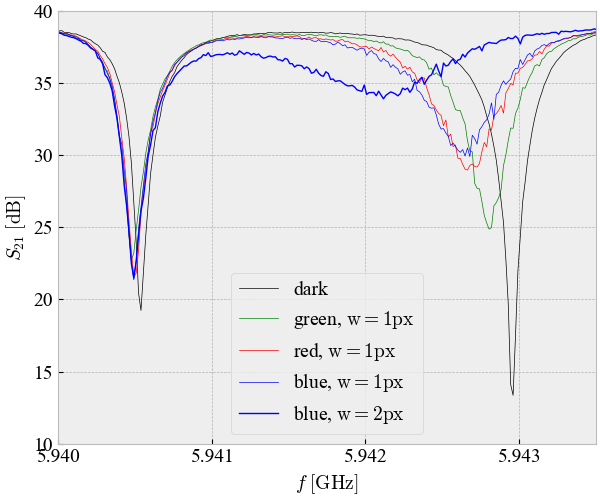

In [2]:
dir = 'S21s/19-10-23/S21_x540y1119_'
date = '9h58_19-10-2023'
darkname = dir + date + '_dark.npy'
freqsname = dir + date + '_freqs.npy'
dark = np.load(darkname)
freqs = np.load(freqsname)

def get_s21(w, c):
    dir = 'S21s/19-10-23/S21_x540y1119'
    date = '9h58_19-10-2023'
    name = '%s_w%d_%s_%s.npy' % (dir, w, c, date)
    return np.load(name) 

fig, ax = plt.subplots(figsize=(6, 5), constrained_layout=True)
w = 0.5
ax.plot(freqs, dark, c='k', lw=w, label='dark')
ax.set_xlabel('$\it f$ $[GHz]$')
ax.set_ylabel('$\it S_{21}$ $[dB]$')
# ax.set_title('Transmission 400 pixels on single readout line')
ax.plot(freqs, get_s21(1, 'green'), c='g', lw=1*w, label='green, $w=1 px$')
# ax.plot(freqs, get_s21(1, 'white'), c='k', ls='--')
# ax.plot(freqs, get_s21(2, 'white'), c='k', lw=2, ls='--')
ax.plot(freqs, get_s21(1, 'red'), c='r', lw=1*w, label='red, $w=1 px$')
ax.plot(freqs, get_s21(1, 'blue'), c='b', lw=1*w, label='blue, $w=1 px$')
ax.plot(freqs, get_s21(2, 'blue'), c='b', lw=2*w, label='blue, $w=2 px$')
ax.legend()
# ax.plot(freqs, get_s21(3, 'blue'), c='b', lw=3)
ax.set_xlim([5.94, 5.9435])
ax.set_ylim([10, 40])
ax.set_xticks([5.94, 5.941, 5.942, 5.943])


In [ ]:
plt.savefig('linewidth2.svg')

In [ ]:
f0s = np.load('./LT295_400pxl_design/resonance_freq_SONNET.npy')
Lfs = np.load('./LT295_400pxl_design/finger_cuts_SONNET.npy')

In [ ]:
Lfs.shape